In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

dataset = fetch_california_housing()

X = pd.DataFrame(dataset.data)
y = pd.DataFrame(dataset.target)
X_np = X.values
indices = list(range(len(X_np)))

In [2]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='softmax'),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
import numpy as np

class KDNode:
  def __init__(self, points, axis, index, right=None, left=None):
    self.points = points
    self.axis = axis
    self.right = right
    self.left = left
    self.index = index

# np.array(..., dtype=KDnode)

def distance_squared(p1, p2):
  return np.sum((np.array(p1) - np.array(p2)))

def knn_search(root, target, k, depth=0, heap=None):
  import heapq

  if root is None:
    return

  if heap is None:
    heap = []

  axis = root.axis

  dist = distance_squared(target, root.points)

  heapq.heappush(heap, (-dist, root.index))
  if len(heap) > k:
    heapq.heappop(heap)

  if target[axis] < root.points[axis]:
    next_branch = root.left
    opposite_branch = root.left
  else:
    next_branch = root.right
    opposite_branch = root.left

  knn_search(next_branch, target, k, depth + 1, heap)

  if len(heap) < k or (target[axis] - root.points[axis])**2 < - heap[0][0]:
    knn_search(opposite_branch, target, k, depth + 1, heap)

  return heap

def build_kdtree(points, indices, depth=0):
  if len(points) == 0:
    return None

  k = len(points[0])
  axis = depth % k

  combined = list(zip(points, indices))
  combined.sort(key=lambda x: x[0][axis])

  median = len(combined) // 2

  point, index = combined[median]

  left_points = [x[0] for x in combined[:median]]
  left_indices = [x[1] for x in combined[:median]]

  right_points = [x[0] for x in combined[median + 1:]]
  right_indices = [x[1] for x in combined[median + 1:]]

  return KDNode(
      points=point,
      index=index,
      axis=axis,
      left=build_kdtree(left_points, left_indices, depth + 1),
      right=build_kdtree(right_points, right_indices, depth + 1)
  )

def knn_predict(tree, y_train, query, k=5):
    neighbors = knn_search(tree, query, k)
    indices = [idx for (_, idx) in neighbors]
    return np.mean(y_train.iloc[indices].values)




In [5]:
tree = build_kdtree(X_np.tolist(), indices)


In [7]:
prediction = knn_predict(tree, y, X_np[0], k=5)
print("Prediction:", prediction)
print("True value:", y.iloc[0].values)


Prediction: 2.958602
True value: [4.526]


In [9]:
X_2d = X_np[:, :2]
indices_2d = list(range(len(X_2d)))

tree_2d = build_kdtree(X_2d.tolist(), indices_2d)

In [12]:
import matplotlib.pyplot as plt

def plot_kdtree(node, xmin, xmax, ymin, ymax, depth=0):
  if node is None:
    return

  axis = node.axis
  x, y = node.points

  if axis == 0:
    plt.plot([x, x], [ymin, ymax], 'r-')
    plot_kdtree(node.left, xmin, x, ymin, ymax, depth+1)
    plot_kdtree(node.right, x,xmax, ymin, ymax, depth+1)
  else:
    plt.plot([xmin, xmax], [y, y], 'b-')
    plot_kdtree(node.left, xmin, xmax, ymin, y, depth+1)
    plot_kdtree(node.right, xmin, xmax, y, ymax, depth+1)


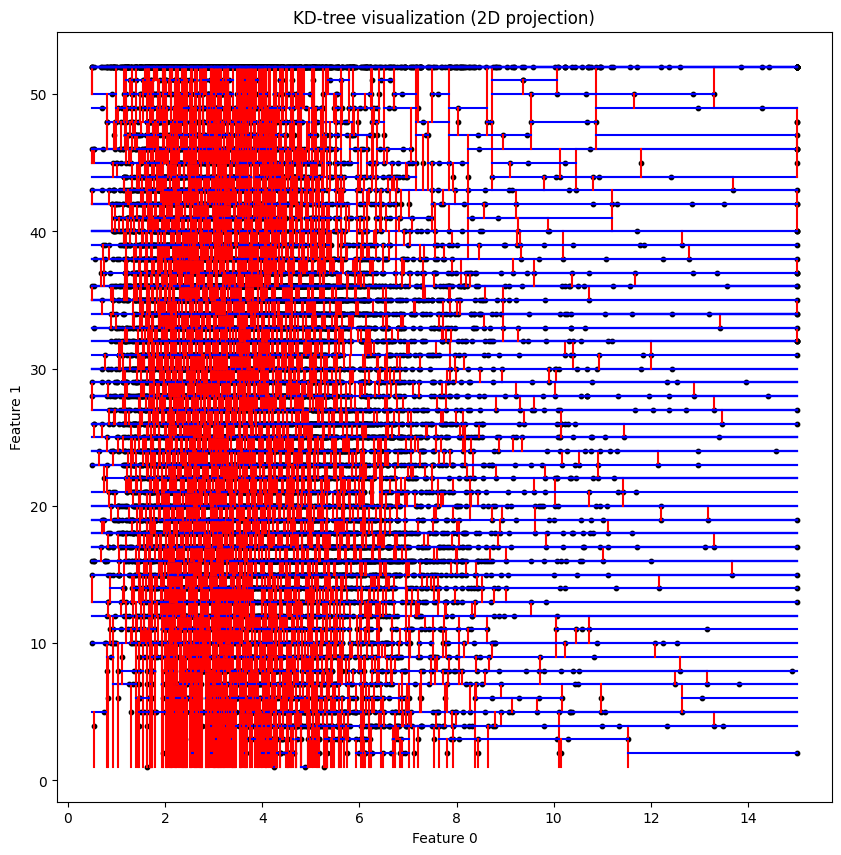

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, c='black')
plot_kdtree(tree_2d, X_2d[:, 0].min(), X_2d[:, 0].max(), X_2d[:, 1].min(), X_2d[:, 1].max())
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("KD-tree visualization (2D projection)")
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


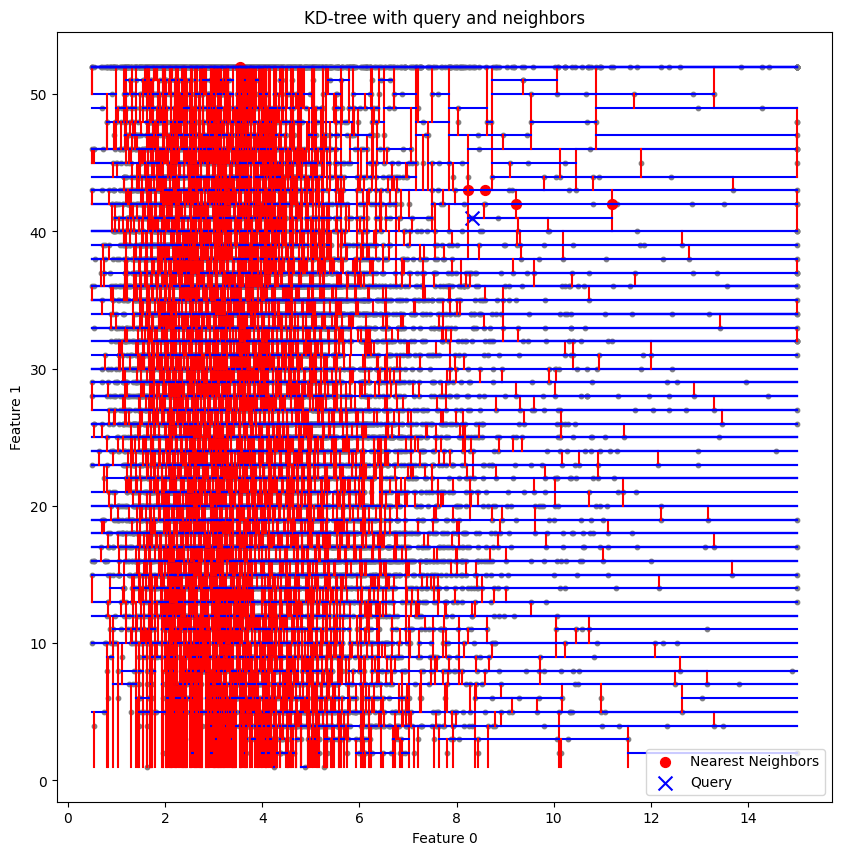

In [14]:
query = X_2d[0]  # pick first point
neighbors = knn_search(tree_2d, query, k=5)
neighbor_indices = [idx for (_, idx) in neighbors]

plt.figure(figsize=(10, 10))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, c='gray')
plt.scatter(X_2d[neighbor_indices, 0], X_2d[neighbor_indices, 1],
            s=50, c='red', label='Nearest Neighbors')
plt.scatter(query[0], query[1], s=100, c='blue', marker='x', label='Query')
plot_kdtree(tree_2d, X_2d[:, 0].min(), X_2d[:, 0].max(),
            X_2d[:, 1].min(), X_2d[:, 1].max())
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("KD-tree with query and neighbors")
plt.legend()
plt.show()
